Pietro Servadio, Vasu Bansal

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np

from matplotlib import pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# train_data = tf.data.Dataset.from_tensor_slices((train_images.astype(np.float32) / 255, train_labels.reshape(-1).astype(np.int32)))
# train_data = train_data.shuffle( buffer_size = 1000).batch(128)

# test_data = tf.data.Dataset.from_tensor_slices((test_images.astype(np.float32) / 255, test_labels.reshape(-1).astype(np.int32)))

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
regularizer = tf.keras.regularizers.L2(1e-3)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

optimizer = tf.keras.optimizers.Adam()

In [4]:
n_blocks = 2
n_layers_per_block = 3
growth_rate = 10
n_filters = 13

In [5]:
inputs = keras.Input(shape = (32, 32, 3))

def function1(inputs, n_filters):

  # Normalization
  x = layers.BatchNormalization()(inputs)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(n_filters, kernel_size=1, kernel_initializer='he_uniform')(x)
  x = layers.Conv2D(n_filters, kernel_size=3, padding = 'same', kernel_initializer='he_uniform')(x)
  x = layers.Dropout(0.1)(x)

  return x

In [6]:
def skip_function(inputs, n_filters):

    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    n_feature_maps = inputs.shape[1]
    # Number of features is cut in half
    new_n_feature_maps = 0.5 * n_feature_maps
    x = layers.Conv2D(np.floor(0.5 * n_feature_maps).astype(int), kernel_size=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizer)(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.2)(x)

    return x

In [7]:
def block(inputs, n_layers, n_filters, growth_rate):

    for i in range(n_layers): # number of layers per block
        conv_outputs = function1(inputs, n_filters)
        inputs = layers.Concatenate()([conv_outputs, inputs])
        n_filters += growth_rate # Changing (increasing) the number of filters to add variety

    return inputs, n_filters

In [8]:
inputs = keras.Input(shape = (32, 32, 3))
x = inputs

for i in range(n_blocks):
    x, n_filters = block(x, n_layers_per_block, n_filters, growth_rate)
    if (i != n_blocks - 1):
      x = skip_function(x, n_filters)

## GlobalAveragePooling2D layer ensures that the outputs are 2D
x = layers.GlobalAveragePooling2D()(x)

# A dense layer with softmax activation to ensure the correct output dimension
x = layers.Dense(10)(x)
outputs = layers.Activation('softmax')(x)

In [9]:
model = tf.keras.models.Model(inputs, outputs)
model.compile(optimizer = optimizer, loss = loss_fn, metrics = metrics)

In [10]:
trained_model = model.fit(train_images, train_labels, epochs = 30, batch_size = 128, validation_data = (test_images, test_labels))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 [==============================] - 37s 47ms/step - loss: 1.7547 - sparse_categorical_accuracy: 0.3666 - val_loss: 1.6294 - val_sparse_categorical_accuracy: 0.4081
Epoch 2/30
391/391 [==============================] - 18s 45ms/step - loss: 1.4306 - sparse_categorical_accuracy: 0.4949 - val_loss: 1.3963 - val_sparse_categorical_accuracy: 0.5137
Epoch 3/30
391/391 [==============================] - 18s 45ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.5575 - val_loss: 1.4530 - val_sparse_categorical_accuracy: 0.5339
Epoch 4/30
391/391 [==============================] - 19s 47ms/step - loss: 1.1344 - sparse_categorical_accuracy: 0.6021 - val_loss: 1.2653 - val_sparse_categorical_accuracy: 0.5839
Epoch 5/30
391/391 [==============================] - 17s 44ms/step - loss: 1.0653 - sparse_categorical_accuracy: 0.6263 - val_loss: 1.2227 - val_sparse_categorical_accuracy: 0.5827
Epoch 6/30
391/391 [==============================] - 18s 47ms/step - loss: 1.0204 - sparse_categoric

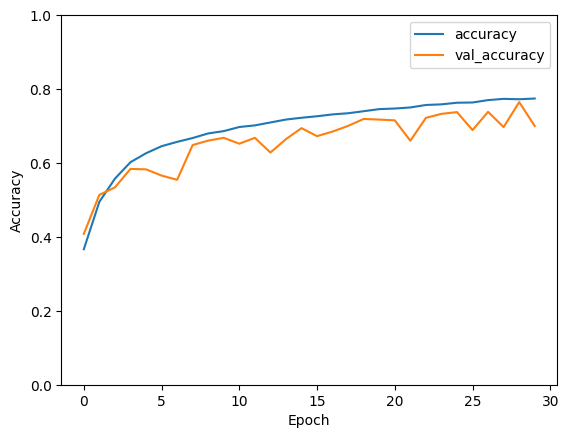

In [13]:
plt.plot(trained_model.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(trained_model.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='best')

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 3)            12        ['input_2[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 3)            0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 13)           52        ['activation[0][0]']      

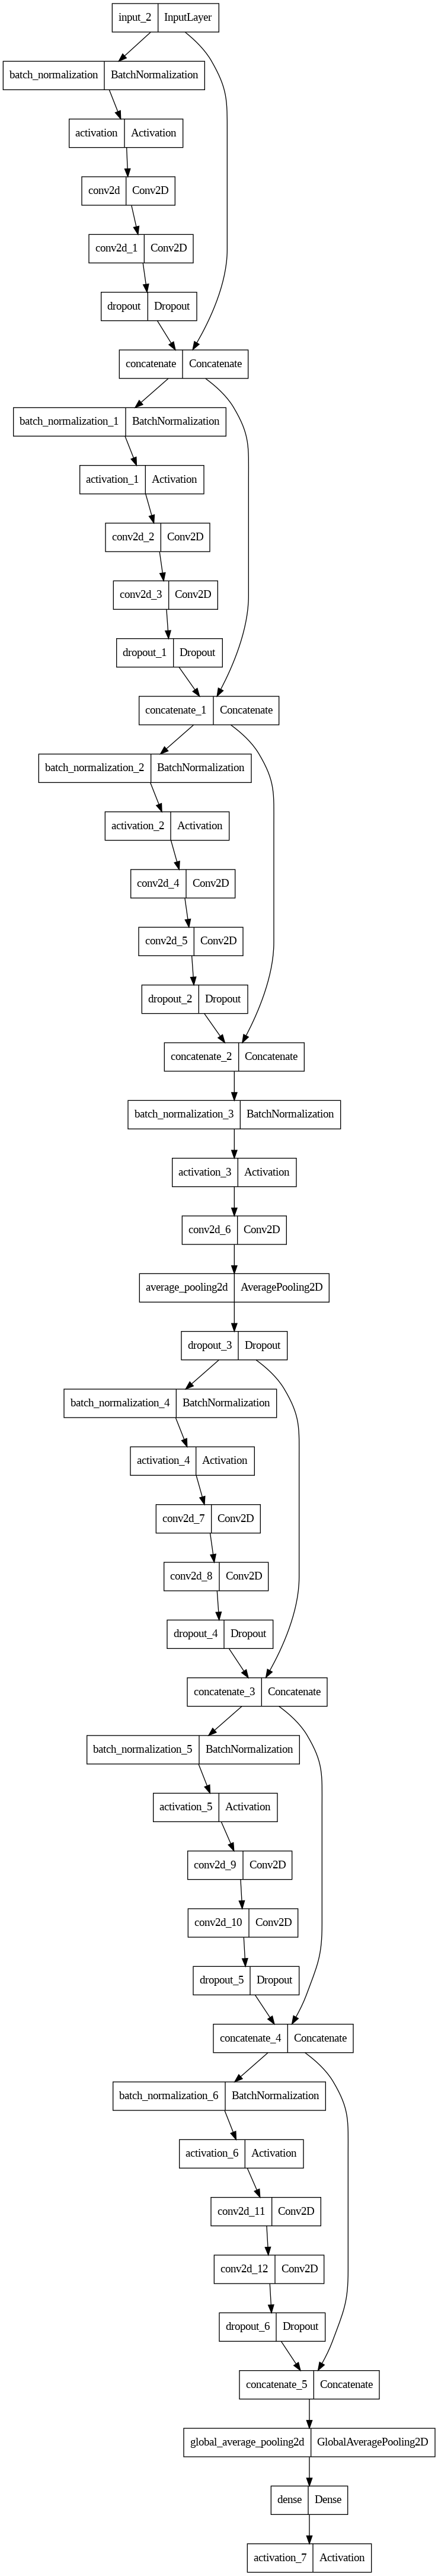

In [12]:
keras.utils.plot_model(model)